In [248]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [249]:
import os
os.chdir(r'/content/drive/MyDrive/projectA/Project_A_Supp')  # Change the directory to torchRay-master folder

# Requirements

In [250]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [251]:
train_dir = '/content/drive/MyDrive/projectA/Project_A_Supp/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/MyDrive/projectA/Project_A_Supp/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [252]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [8]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [9]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [10]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/150
140/140 [==============================] - 861s 6s/step - loss: 2.0002 - accuracy: 0.2245
Epoch 2/150
 84/140 [=================>............] - ETA: 33s - loss: 1.6512 - accuracy: 0.3854

KeyboardInterrupt: ignored

In [ ]:
model.save('HMT.h5')

# Load Model

In [253]:
model=load_model('/content/drive/MyDrive/projectA/Project_A_Supp/models/HMT.h5')

In [254]:
# %cd /content/drive/MyDrive/projectA/
# %pwd

def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator( '/content/drive/MyDrive/projectA/log2/train/' + os.listdir('/content/drive/MyDrive/projectA/log2/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

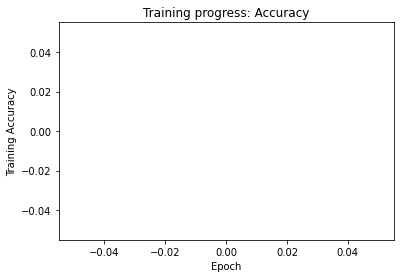

In [13]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

In [ ]:
#loss_test,acc_test=model.evaluate(test,y_test_onehot)

loss_test,acc_test=model.evaluate(test_generator)
print('loss in test:', loss_test)

#Q 3.F
# Y_test = np.argmax(y_test_onehot, axis=1) # Convert one-hot to index
# y_pred = model.predict(test) #x_test
# y_pred_index=np.argmax(y_pred, axis=1)
# print(y_pred)
# print(metrics.classification_report(Y_test,y_pred_index))


# #Q 3,E
# matrix = metrics.confusion_matrix(y_test, y_pred_index)
# print('Confusion matrix is: ')
# print(matrix)

# print('Normalized confusion matrix is: ')
# print(matrix/matrix.sum(axis=1))

# #Q 3.C
# print('The accuracy for each class are: ')
# print(matrix.diagonal()/matrix.sum(axis=1))
# for i in range(10):
#     print('For class ',i,' accuracy is: ', (1000-np.sum(matrix[i,:])-np.sum(matrix[:,i])+2*matrix[i,i])/1000)

In [ ]:
print(metrics.classification_report(test_generator))

# Explanation

Load the explaier library

In [255]:
from xai_utils import *

Load a batch of images

In [256]:
test_generator.reset()

In [257]:
image_batch,label_batch=test_generator.next()



In [258]:
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

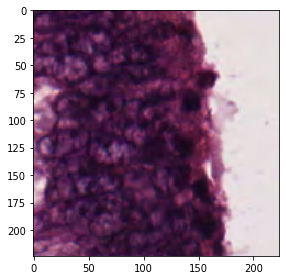

In [259]:
images=image_batch[0]
#images=images[][0]
plt.figure()
skimage.io.imshow(images)

Classes:

In [260]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [261]:
index=8

In [262]:
prediction=model(image_batch)
# print(label_batch)
# print(label_batch[8])
# print(prediction)

print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [220]:
layers=[['conv2d_3']]

In [221]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 3.66 s, sys: 169 ms, total: 3.83 s
Wall time: 2.22 s


## Grad-CAM (Gradient-based Class Activation Mapping)

In [222]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 623 ms, sys: 127 ms, total: 750 ms
Wall time: 526 ms


## RISE (Randomized Input Sampling for Explanation)

In [223]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1min 48s, sys: 1.15 s, total: 1min 49s
Wall time: 59.2 s


## LIME (Randomized Input Sampling for Explanation)

The LIME Code is written based the open resource provided by Cristian Arteaga

https://colab.research.google.com/github/arteagac/arteagac.github.io/blob/master/blog/lime_image.ipynb#scrollTo=LluwEG7fh9Vh

In [264]:
# Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
# Xi = skimage.transform.resize(Xi, (224,224)) 
# Xi = (Xi - 0.5)*2 #Inception pre-processing
# skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing


# np.random.seed(222)
# preds = model.predict(Xi[np.newaxis,:,:,:])
# decode_predictions(preds) #Top 5 classes

In [265]:
image_test=image_batch[index]
np.random.seed(222)
preds = model.predict(image_test[np.newaxis,:,:,:])
#preds = model.predict(image_batch)
#decode_predictions(preds)[0] #Top 5 classes
#top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes      

array([0, 5, 2, 3, 1])

In [266]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([0, 5, 2, 3, 1])

In [267]:
# image_test=image_batch[index]

image_test = cv2.normalize(image_test.astype('double'), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
superpixels = skimage.segmentation.quickshift(image_test, kernel_size=3,max_dist=50, ratio=0.8)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

92

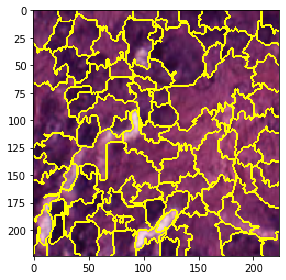

In [268]:

skimage.io.imshow(skimage.segmentation.mark_boundaries(image_test, superpixels))


In [269]:
num_perturb = 280
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1])

In [270]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

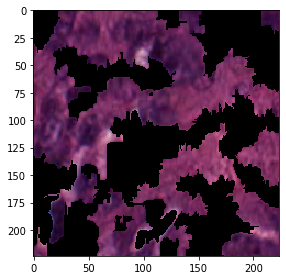

In [271]:
skimage.io.imshow(perturb_image(image_test,perturbations[0],superpixels))

In [272]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(image_test,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(280, 1, 8)

In [273]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(280,)

In [274]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(280,)

In [275]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))


# image_test=image_batch[index]
# np.random.seed(222)
# preds = model.predict(image_test[np.newaxis,:,:,:])
# decode_predictions(preds)[0] #Top 5 classes

class_to_explain = top_pred_classes[0]

simpler_model = LinearRegression()

#simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)

simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff


True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067


array([-3.11287707e-08,  3.02480551e-07,  2.68598080e-07,  3.51047640e-07,
        3.08024993e-07, -7.54145806e-08,  1.41954603e-07,  5.56701792e-07,
        3.77834169e-07,  3.53202259e-07,  3.75662020e-07, -2.46960379e-07,
        2.94685870e-07,  2.86902600e-07,  3.74519186e-07,  8.69314209e-08,
        4.07753428e-07,  2.35459536e-07,  1.20942274e-07,  3.58804836e-07,
        2.41897194e-07,  1.72400428e-07, -9.21974101e-08, -6.53376241e-08,
       -1.66639510e-07, -3.36015895e-07,  2.43754882e-07, -2.54290293e-07,
        2.45049974e-07, -5.35695631e-08, -1.82475803e-07,  1.76057134e-07,
        2.48310861e-08,  5.26696484e-07, -4.18746013e-08,  2.17105888e-07,
        2.69062587e-07,  1.30405641e-07,  7.62196852e-08,  4.68413756e-08,
        1.68632387e-08,  2.24624001e-07,  2.06821429e-07,  9.03041569e-08,
        1.38998536e-08,  2.58504435e-07,  2.61418090e-07,  3.40281121e-07,
        3.03349038e-07, -2.02294590e-08, -6.34348030e-08,  3.69773712e-07,
        4.53939983e-08, -

In [276]:
num_top_features = 92
# print(np.argsort(coeff))
top_features = np.argsort(coeff)[-num_top_features:] 
print(top_features.shape)
top_features

(92,)


array([74, 25, 67, 76, 27, 84, 11, 72, 55, 30, 88, 24, 87, 69, 22, 62,  5,
       23, 50, 59, 29, 34,  0, 49, 53, 70, 77, 44, 40, 32, 78, 71, 52, 64,
       39, 61, 85, 66, 38, 79, 81, 15, 43, 63, 58, 18, 91, 37, 82,  6, 21,
       31, 90, 56, 60, 42, 35, 41, 17, 65, 20, 26, 28, 45, 46,  2, 36, 13,
       12,  1, 48,  4, 68, 47, 83,  3, 89,  9, 19, 54, 51, 14, 10,  8, 16,
       75, 57, 86, 73, 33,  7, 80])

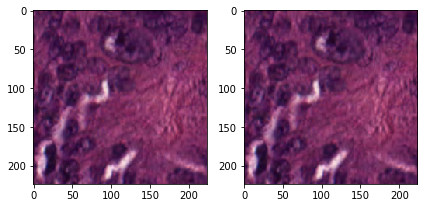

In [277]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
plt.subplot(1,2,1)
skimage.io.imshow(perturb_image(image_test,mask,superpixels) )

plt.subplot(1,2,2)
skimage.io.imshow(image_test )

In [278]:
#preds = model.predict(image_test[np.newaxis,:,:,:])
#preds = model.predict(image_batch)
# !pip install lime

# import lime
# from lime import lime_image
# from skimage.segmentation import mark_boundaries



In [279]:
# explainer = lime_image.LimeImageExplainer()
# explanation = explainer.explain_instance(image_test, model.predict, top_labels=5, hide_color=0, num_samples=1000)
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=True)
# lime = mark_boundaries(temp, mask)

# #plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
# plt.imshow(lime)


## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

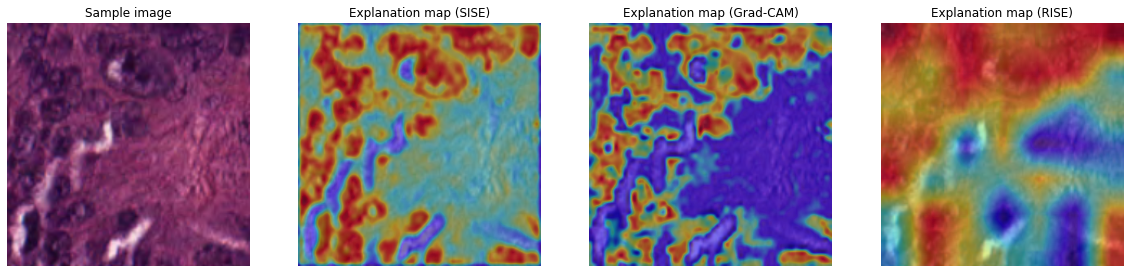

In [30]:
#@title Plot the results

# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# plt.imshow(image_batch[index])
# plt.axis('off')
# plt.title('Sample image')

# plt.subplot(1,4,2)
# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (SISE)')

# plt.subplot(1,4,3)
# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (Grad-CAM)')

# plt.subplot(1,4,4)
# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (RISE)')



In [41]:
# def LIME():
#   image_test=image_batch[index]
#   np.random.seed(222)
#   preds = model.predict(image_test[np.newaxis,:,:,:])
#   #preds = model.predict(image_batch)
#   #decode_predictions(preds)[0] #Top 5 classes
#   #top_pred_classes = preds[0].argsort()[-5:][::-1]
#   top_pred_classes = preds[0].argsort()[-5:][::-1]
#   top_pred_classes

#   image_test = cv2.normalize(image_test.astype('double'), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
#   superpixels = skimage.segmentation.quickshift(image_test, kernel_size=3,max_dist=50, ratio=0.8)
#   num_superpixels = np.unique(superpixels).shape[0]
       
#   num_perturb = 280
#   perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#   def perturb_image(img,perturbation,segments):
#     active_pixels = np.where(perturbation == 1)[0]
#     mask = np.zeros(segments.shape)
#     for active in active_pixels:
#         mask[segments == active] = 1 
#     perturbed_image = copy.deepcopy(img)
#     perturbed_image = perturbed_image*mask[:,:,np.newaxis]
#     return perturbed_image

  
#   predictions = []
#   for pert in perturbations:
#     perturbed_img = perturb_image(image_test,pert,superpixels)
#     pred = model.predict(perturbed_img[np.newaxis,:,:,:])
#     predictions.append(pred)

#   predictions = np.array(predictions)

#   original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
#   distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
#   distances.shape

#   kernel_width = 0.25
#   weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
  
#   prediction=model(image_batch)
#   class_to_explain = top_pred_classes[0]

#   simpler_model = LinearRegression()

#   #simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)

#   simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
#   coeff = simpler_model.coef_[0]
#   num_top_features = 92
#   # print(np.argsort(coeff))
#   top_features = np.argsort(coeff)[-num_top_features:] 
#   mask = np.zeros(num_superpixels) 
#   mask[top_features]= True #Activate top superpixels
#   return mask,superpixels

In [263]:
# mask[top_features]= True #Activate top superpixels
# explanation_map_RISE -= explanation_map_RISE.min()
# explanation_map_RISE /= explanation_map_RISE.max()+10e-30

mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels


explanation_map_LIME_3=perturb_image(image_test,mask,superpixels)
explanation_map_LIME = explanation_map_LIME_3[:,:,0]+explanation_map_LIME_3[:,:,1]+explanation_map_LIME_3[:,:,2]
explanation_map_LIME = explanation_map_LIME/3
explanation_map_LIME -= explanation_map_LIME.min()
explanation_map_LIME /= explanation_map_LIME.max()+10e-30


mask2= np.ones(num_superpixels)
mask2[top_features]= True

explanation_map_LIME_32=perturb_image(image_test,mask,superpixels)
explanation_map_LIME2 = explanation_map_LIME_32[:,:,0]+explanation_map_LIME_32[:,:,1]+explanation_map_LIME_32[:,:,2]
explanation_map_LIME2 = explanation_map_LIME2/3
explanation_map_LIME2 -= explanation_map_LIME2.min()
explanation_map_LIME2 /= explanation_map_LIME2.max()+10e-30

plt.imshow(image_batch[index])
plt.imshow(explanation_map_LIME, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (LIME)')



NameError: ignored

True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.90054935


Text(0.5, 1.0, 'Explanation map (LIME)')

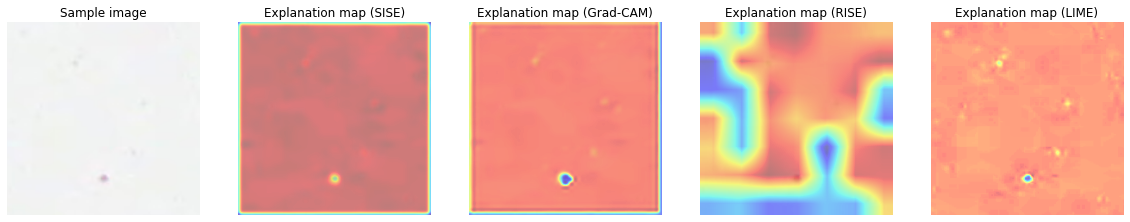

In [241]:
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,5,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,5,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,5,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

plt.subplot(1,5,5)
plt.imshow(explanation_map_LIME, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (LIME)')

In [ ]:
# mask2= np.ones(num_superpixels)
# mask2[top_features]= True

# map_LIME_32=perturb_image(image_test,mask,superpixels)
# explanation_map_LIME2 = explanation_map_LIME_32[:,:,0]+explanation_map_LIME_32[:,:,1]+explanation_map_LIME_32[:,:,2]
# explanation_map_LIME2 = explanation_map_LIME2/3
# explanation_map_LIME2 -= explanation_map_LIME2.min()
# explanation_map_LIME2 /= explanation_map_LIME2.max()+10e-30

# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_LIME2, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (LIME)')

## Quantitative evaluation of the explanation algorithm

In [280]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [243]:
test_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

KeyboardInterrupt: ignored

In [281]:
def Lime():
  prediction=model(image_batch)
  # print('True label: '+classes[np.argmax(label_batch[index])])
  # print('Predicted_label: '+classes[np.argmax(prediction[index])])
  # print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))


  # image_test=image_batch[index]
  # np.random.seed(222)
  # preds = model.predict(image_test[np.newaxis,:,:,:])
  # decode_predictions(preds)[0] #Top 5 classes

  class_to_explain = top_pred_classes[0]

  simpler_model = LinearRegression()

  #simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)

  simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
  coeff = simpler_model.coef_[0]
  #coeff
  num_top_features = 92
  # print(np.argsort(coeff))
  top_features = np.argsort(coeff)[-num_top_features:] 
  #print(top_features.shape)
  #top_features

  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels

  explanation_map_LIME_3=perturb_image(image_test,mask,superpixels)
  explanation_map_LIME = explanation_map_LIME_3[:,:,0]+explanation_map_LIME_3[:,:,1]+explanation_map_LIME_3[:,:,2]
  explanation_map_LIME = explanation_map_LIME/3
  explanation_map_LIME -= explanation_map_LIME.min()
  explanation_map_LIME /= explanation_map_LIME.max()+10e-30
  return explanation_map_LIME

In [284]:
test_generator.reset()
drop_rate = 0.
inc_rate=0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Lime = Lime()
        array=calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Lime, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate += array[0]
        inc_rate+=array[1]
drop_rate /= (15*32)
inc_rate/= (15*32)

In [289]:
print('drop_rate of LIME in HMT:',drop_rate)
print('inc_rate of LIME in HMT:',inc_rate)

drop_rate of LIME in HMT: 0.6462995754312103
inc_rate of LIME in HMT: 0.24583333333333332
